# 2. Advanced Algorithms

(Large part of discussion on Euler method lifted from current part II course presentations)

We learnt some basic algorithms last year: the Euler method and the trapezium rule. You may vaguely remember big O notation from Maths last year (Or you may be bored of it if you did Computer Science!). We can also use these when we talk about algorithms. If we say a function $f(x)$ is $O(g(x))$, we mean to say that there exists some $k$ such that $f(x) \leq kg(x)$ for all $x$ in some bound we specify. When we talk about algorithms, there are two important metrics which we will measure using big O notation:

* The time it takes to finish the computation given some characteristic of the system
    
    * e.g. If we naïvely simulate n colliding particles in a box, it takes $O(n^2)$ time to take a step, but by assuming some properties, we can bring this down to $O(nlog(n))$
    
    * It is an important measure of performance as by Moore's law, computers become 2x as fast every year, so an algorithm that is a constant factor, e.g. one that is twice as fast, can be easily emulated either by buying a better computer or waiting a year and buying the same computer.
    
* Perhaps more importantly at this stage (As it is not expected you will be coding performance-critical algorithms at this stage), it is also used as a measure of the error of an algorithm.

### The error in the Euler method

A Taylor expansion of any function can be constructed as follows:

$$ f(x + \Delta x) = f(x) + \Delta x f'(x) + \frac{{\Delta x}^2}{2} f''(x) + ... $$

If we truncate the series after the linear term, we get the Euler method:

$$ f(x + \Delta x) = f(x) + \Delta x f'(x) $$

As we have discarded the $O(\Delta x^2)$ term, we therefore have an error of $O(\Delta x^2)$ in every step. To simulate a system for a certain time, we need to take $O(\Delta x^{-1})$ steps, so the total error is $ O(\Delta x) $ if we assume errors accumulate. Therefore, the Euler method is a first order method. We can do better.

### The error in the Trapezium rule

The derivation for the error in the trapezium rule is a bit more involved and will not be explained here. The proofs can be found online if one so wishes, but the result is that the error is of $O(\Delta x^2)$, one order better than the Euler method. We can do yet better.

### Better methods: Runge-Kutta

Runge-Kutta methods are a family of integration methods, of which the most famous one, *the* Runge-Kutta method (Also often referred to as RK4) is specified as follows:

For the situation where

$ y' = f(t,y), y(t_0) = y_0 $, calculate $k_1, k_2, k_3, k_4$ where they are defined as:

$$ k_1 = f(t_n, y_n),$$

$$ k_2 = f(t_n + \frac{\Delta t}{2}, y_n + \frac{\Delta t}{2} k_1),$$

$$ k_3 = f(t_n + \frac{\Delta t}{2}, y_n + \frac{\Delta t}{2} k_2),$$

$$ k_4 = f(t_n + \Delta t, y_n + \Delta t k_3)$$,

$$ y_{n+1} = y_n + \frac{\Delta t}{6}(k_1 + 2 k_2 +2k_3 +k_4)$$,

$$ t_{n+1} = t_n +\Delta t $$

Although this method is a bit more faff, it is a lot more accurate: the local error is $O( \Delta t^5)$, and the total error is $O(\Delta t^4)$. We'll try implementing it for the example of a rocket, which we implemented last year with Runge-Kutta. We will follow the same format as we did with and graph the results:

In [35]:
import copy
from math import log
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def euler_step_time():
    global m_change_rate, delta_t, m_rocket, v_ejecta, v_rocket
    m_change = m_change_rate * delta_t
    m_rocket += m_change
    force = - m_change_rate * v_ejecta
    accel = force/m_rocket
    v_rocket += accel*delta_t

def rk4_step_time():
    global m_change_rate, delta_t, m_rocket, v_ejecta, v_rocket
    m_change = m_change_rate * delta_t/2
    force = - m_change_rate * v_ejecta
    k1 = force/m_rocket
    m_rocket += m_change
    k2 = force/m_rocket
    k3 = force/m_rocket
    m_rocket += m_change
    k4 = force/m_rocket
    v_rocket += (k1+2*k2+2*k3+k4) * delta_t/6
    
def analytic_soln():
    global m_change_rate, delta_t, m_rocket, v_ejecta, v_rocket
    return v_ejecta * log(initial_m_rocket / m_rocket)

m_change_rate = -0.1
v_ejecta = 5.
delta_t = 5.
m_rocket = 10.
initial_m_rocket = copy.copy(m_rocket)
v_rocket = 0.
t = []
euler = []
m = []
analytic = []
current_t = 0.
max_t = 95.

while current_t < max_t:
    euler_step_time()
    t.append(current_t)
    euler.append(v_rocket)
    m.append(m_rocket)
    analytic.append(analytic_soln())
    current_t += delta_t

In [36]:
m_rocket = copy.copy(initial_m_rocket)
v_rocket = 0.
rk4 = []
current_t = 0.

while current_t < max_t:
    rk4_step_time()
    rk4.append(v_rocket)
    current_t += delta_t

<IPython.core.display.Javascript object>


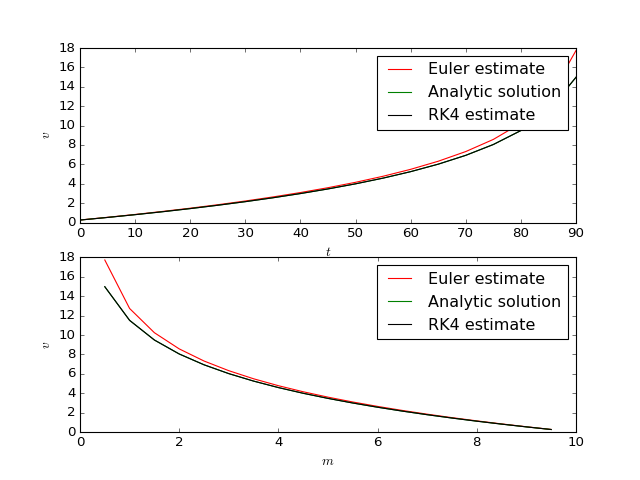

In [37]:
fig = plt.figure()

ax = plt.subplot(211);
ax1 = plt.subplot(212);

# Label the axes
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v$')

ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$v$')

ax.plot(t, euler, label='Euler estimate', color='r')
ax.plot(t, analytic, label='Analytic solution', color='g')
ax.plot(t, rk4, label='RK4 estimate', color='k')
ax.legend()

ax1.plot(m, euler, label='Euler estimate', color='r')
ax1.plot(m, analytic, label='Analytic solution', color='g')
ax1.plot(m, rk4, label='RK4 estimate', color='k')
ax1.legend()

As you can see, it is a lot more accurate, even with higher values of $\Delta t$, thanks to the errors being $O(\Delta t^4)$.

### Better methods: Verlet integration

RK4 is great, but it still has the same flaw as with the Euler method: it doesn't conserve energy when simulating physical systems. This is, as you can imagine, a problem. Instead, one can use Verlet integration, an algorithm which approximately conserves energy, and which is time-reversible, properties which real, physical systems have as well. We will look at the Velocity Verlet algorithm for a physical system:

$$ x_{n+1} = x_n + v_n \Delta t + \frac{1}{2} a(t) \Delta t^2 $$

$$ v_{n+1} = v_n + \frac{a(t) + a(t + \Delta t)}{2} \Delta t $$

The Verlet integrator has local error $O(t^4)$, with global error $O(t^2)$, so it is inferior to the RK4 method in this respect. However, the Verlet method is still useful due to the properties outlined above. Although more complex, there are alos higher order Verlet methods as well. Try implementing the Velocity Verlet algorithm written above in Python.